# Part of Speech Tagging in PyTorch

## Part 1: Dataset Exploration

In [1]:
from src.data_module.udpos_dataset import UDPOS

d:\Projects\POS_Tagging\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
udpos = UDPOS()

### 2.1. Dataset Shape

Let's check the number of training examples in each dataset split.

In [3]:
print(f"Number of training examples: {len(udpos.train)}")
print(f"Number of validation examples: {len(udpos.val)}")
print(f"Number of testing examples: {len(udpos.test)}")

Number of training examples: 12543
Number of validation examples: 2002
Number of testing examples: 2077


This is what each example looks like. Here,
* The `text` field will be used as feature for the POS tagger model.
* The `udtags` field will be used as labels.

In [4]:
example = vars(udpos.train.examples[0])
print("Text\n", ' '.join(example['text']))
print("UD Tags\n", example['udtags'])

Text
 al - zaman : american forces killed shaikh abdullah al - ani , the preacher at the mosque in the town of qaim , near the syrian border .
UD Tags
 ['PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'VERB', 'PROPN', 'PROPN', 'PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'PROPN', 'PUNCT', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT']


###  2.2. Analyzing Vocabulary

The fields are preprocessed. This means, the tokenization step has been performed. Let's check what the vocabulary size is for each field.

In [5]:
print(f"Unique tokens in TEXT vocabulary: {len(udpos.TEXT.vocab)}")
print(f"Unique tokens in UD_TAG vocabulary: {len(udpos.UD_TAGS.vocab)}")

Unique tokens in TEXT vocabulary: 8866
Unique tokens in UD_TAG vocabulary: 18


Let's see what the top 10 most common tokens in `text` are.

In [6]:
TOP = 10

print(f"Top {TOP} most common tokens in text are as follows:")

for i, (token, count) in enumerate(udpos.TEXT.vocab.freqs.most_common(TOP)):
    print(f"{i+1:>2}) {token:<5} has count {count:>5}")

Top 10 most common tokens in text are as follows:
 1) the   has count  9076
 2) .     has count  8640
 3) ,     has count  7021
 4) to    has count  5137
 5) and   has count  5002
 6) a     has count  3782
 7) of    has count  3622
 8) i     has count  3379
 9) in    has count  3112
10) is    has count  2239


Let's check out how many distinct POS tags there are in `udtags`.

In [7]:
unique_pos_tags = len(udpos.UD_TAGS.vocab)

print(f"There are {unique_pos_tags} in total which are as follows")

for i, (tag, count) in enumerate(udpos.UD_TAGS.vocab.freqs.most_common()):
    print(f"{i+1:>2}) {tag:>6} ({count})")

There are 18 in total which are as follows
 1)   NOUN (34781)
 2)  PUNCT (23679)
 3)   VERB (23081)
 4)   PRON (18577)
 5)    ADP (17638)
 6)    DET (16285)
 7)  PROPN (12946)
 8)    ADJ (12477)
 9)    AUX (12343)
10)    ADV (10548)
11)  CCONJ (6707)
12)   PART (5567)
13)    NUM (3999)
14)  SCONJ (3843)
15)      X (847)
16)   INTJ (688)
17)    SYM (599)


### 2.3. Batch Iterator

Our model will use vectorzied computation to be efficient. For that, we need to iterate over the dataset in batches. 

Let's see what the iterator looks like.

In [8]:
for batch in udpos.train_dataloader():
    print(batch[0].shape, batch[1].shape)
    break

torch.Size([79, 64]) torch.Size([79, 64])


In [9]:
for batch in udpos.val_dataloader():
    print(batch[0].shape, batch[1].shape)
    break

torch.Size([1, 64]) torch.Size([1, 64])


Each batch has two objects containing `text` and `udtags`. The shape of both the fields is $x \times 64$. Here's what this means:

* **Number of steps**: x. Meaning, there are x sequential tokens. 
* **Batches**: 64. Meaning, there are 64 different sequences.

Let's look at a breakdown of one row.

In [10]:
for batch in udpos.train_dataloader():
    text, tags = batch

    print("Text:", " ".join(udpos.TEXT.vocab.itos[i]
                            for i in text[0]))
    print("Tags:", " ".join(udpos.UD_TAGS.vocab.itos[i]
                            for i in tags[0]))

    break

Text: lemelpe@nu.com you agel fantastic no " this voters caroline or thank <unk> why zacarias sounds the thanks i ( last but we <unk> .. ( ---------------------------------------------------------------------- i she in the earl vince and i you fyi <unk> i should the yet the 2 there i the '' they on 100 thank in i i we might game other the next he but good thank
Tags: X PRON PROPN ADJ DET PUNCT PRON NOUN X CCONJ VERB X ADV PROPN VERB DET NOUN PRON PUNCT ADJ CCONJ PRON NOUN PUNCT PUNCT PUNCT PRON PRON ADP DET PROPN PROPN CCONJ PRON PRON ADV NOUN PRON AUX DET CCONJ DET X PRON PRON DET PUNCT PRON ADP NUM VERB ADP PRON PRON PRON AUX NOUN ADJ DET ADJ PRON CCONJ ADJ VERB


Transposing the filed values, their shape becomes $64 \times 65$. So each row is now one example sentence. Thus the sentence makes sense when we print it. In the LSTM model, we'll iterate over timesteps and look at a batch of examples.

## Part 2: Model Creation

In [11]:
import torch

Let's first specify some hyperparameter values. These will dictate the architectural constraints of our model.

In [12]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
BATCH_SIZE = 64
NUM_LAYERS = 2

### 2.1. Base LSTM Model

In [13]:
from src.module.lstm import LSTM

In [14]:
model = LSTM(num_inputs=EMBEDDING_DIM, num_hiddens=HIDDEN_DIM)

In [15]:
print("List of parameters making up the LSTM model")

for name, params in model.named_parameters():
    print(f"{name:<5} with shape {params.shape}")

List of parameters making up the LSTM model
W_xf  with shape torch.Size([100, 128])
W_hf  with shape torch.Size([128, 128])
b_f   with shape torch.Size([128])
W_xi  with shape torch.Size([100, 128])
W_hi  with shape torch.Size([128, 128])
b_i   with shape torch.Size([128])
W_xo  with shape torch.Size([100, 128])
W_ho  with shape torch.Size([128, 128])
b_o   with shape torch.Size([128])
W_xc  with shape torch.Size([100, 128])
W_hc  with shape torch.Size([128, 128])
b_c   with shape torch.Size([128])


In [16]:
dummy_inputs = torch.randn((65, BATCH_SIZE, EMBEDDING_DIM))
outputs, (H, C) = model(dummy_inputs)

In [17]:
print("Number of outputs:", len(outputs))
print("Shape of Hidden State:", H.shape)
print("Shape of Memory Cell State:", C.shape)

Number of outputs: 65
Shape of Hidden State: torch.Size([64, 128])
Shape of Memory Cell State: torch.Size([64, 128])


Output dimensions match expected values. So our implementation is correct.

### 2.2. Bidirectional LSTM

In [18]:
from src.module.bi_lstm import BiLSTM

In [19]:
model = BiLSTM(num_inputs=EMBEDDING_DIM, num_hiddens=HIDDEN_DIM)

In [20]:
print("List of parameters making up the LSTM model")

for name, params in model.named_parameters():
    print(f"{name:<20} with shape {params.shape}")

List of parameters making up the LSTM model
forward_lstm.W_xf    with shape torch.Size([100, 128])
forward_lstm.W_hf    with shape torch.Size([128, 128])
forward_lstm.b_f     with shape torch.Size([128])
forward_lstm.W_xi    with shape torch.Size([100, 128])
forward_lstm.W_hi    with shape torch.Size([128, 128])
forward_lstm.b_i     with shape torch.Size([128])
forward_lstm.W_xo    with shape torch.Size([100, 128])
forward_lstm.W_ho    with shape torch.Size([128, 128])
forward_lstm.b_o     with shape torch.Size([128])
forward_lstm.W_xc    with shape torch.Size([100, 128])
forward_lstm.W_hc    with shape torch.Size([128, 128])
forward_lstm.b_c     with shape torch.Size([128])
backward_lstm.W_xf   with shape torch.Size([100, 128])
backward_lstm.W_hf   with shape torch.Size([128, 128])
backward_lstm.b_f    with shape torch.Size([128])
backward_lstm.W_xi   with shape torch.Size([100, 128])
backward_lstm.W_hi   with shape torch.Size([128, 128])
backward_lstm.b_i    with shape torch.Size([12

In [21]:
outputs, (f_h, b_h) = model(dummy_inputs)

In [22]:
print("Outputs shape:", len(outputs))
print("Shape of Forward Hidden State:", f_h[0].shape)
print("Shape of Forward Memory Cell:", f_h[1].shape)
print("Shape of backward Hidden State:", b_h[0].shape)
print("Shape of backward Memory Cell:", b_h[1].shape)

Outputs shape: 65
Shape of Forward Hidden State: torch.Size([64, 128])
Shape of Forward Memory Cell: torch.Size([64, 128])
Shape of backward Hidden State: torch.Size([64, 128])
Shape of backward Memory Cell: torch.Size([64, 128])


Output, hidden state, and memory cell shapes are as expected. So the implementation is correct.

### 2.3. Deep LSTMs

In [23]:
from src.module.deep_lstm import DeepLSTM

In [24]:
model = DeepLSTM(num_inputs=EMBEDDING_DIM,
                 num_hiddens=HIDDEN_DIM,
                 num_layers=NUM_LAYERS,
                 bidirectional=False)

In [25]:
print("List of parameters making up the LSTM model")

for name, params in model.named_parameters():
    print(f"{name:<20} with shape {params.shape}")

List of parameters making up the LSTM model
layers.0.W_xf        with shape torch.Size([100, 128])
layers.0.W_hf        with shape torch.Size([128, 128])
layers.0.b_f         with shape torch.Size([128])
layers.0.W_xi        with shape torch.Size([100, 128])
layers.0.W_hi        with shape torch.Size([128, 128])
layers.0.b_i         with shape torch.Size([128])
layers.0.W_xo        with shape torch.Size([100, 128])
layers.0.W_ho        with shape torch.Size([128, 128])
layers.0.b_o         with shape torch.Size([128])
layers.0.W_xc        with shape torch.Size([100, 128])
layers.0.W_hc        with shape torch.Size([128, 128])
layers.0.b_c         with shape torch.Size([128])
layers.1.W_xf        with shape torch.Size([128, 128])
layers.1.W_hf        with shape torch.Size([128, 128])
layers.1.b_f         with shape torch.Size([128])
layers.1.W_xi        with shape torch.Size([128, 128])
layers.1.W_hi        with shape torch.Size([128, 128])
layers.1.b_i         with shape torch.Size([12

In [26]:
outputs, Hs = model(dummy_inputs)

In [27]:
print("Output shape:", outputs.shape)

for i, h in enumerate(Hs):
    print(f"Layer {i+1}: Shape of Hidden State:", h[0].shape)
    print(f"Layer {i+1}: Shape of Memory Cell:", h[1].shape)

Output shape: torch.Size([65, 64, 128])
Layer 1: Shape of Hidden State: torch.Size([64, 128])
Layer 1: Shape of Memory Cell: torch.Size([64, 128])
Layer 2: Shape of Hidden State: torch.Size([64, 128])
Layer 2: Shape of Memory Cell: torch.Size([64, 128])


### 2.4. Deep Bidrectional LSTM

In [28]:
model = DeepLSTM(num_inputs=EMBEDDING_DIM,
                 num_hiddens=HIDDEN_DIM,
                 num_layers=NUM_LAYERS,
                 bidirectional=True)

In [29]:
print("List of parameters making up the LSTM model")

for name, params in model.named_parameters():
    print(f"{name:<20} with shape {params.shape}")

List of parameters making up the LSTM model
layers.0.forward_lstm.W_xf with shape torch.Size([100, 128])
layers.0.forward_lstm.W_hf with shape torch.Size([128, 128])
layers.0.forward_lstm.b_f with shape torch.Size([128])
layers.0.forward_lstm.W_xi with shape torch.Size([100, 128])
layers.0.forward_lstm.W_hi with shape torch.Size([128, 128])
layers.0.forward_lstm.b_i with shape torch.Size([128])
layers.0.forward_lstm.W_xo with shape torch.Size([100, 128])
layers.0.forward_lstm.W_ho with shape torch.Size([128, 128])
layers.0.forward_lstm.b_o with shape torch.Size([128])
layers.0.forward_lstm.W_xc with shape torch.Size([100, 128])
layers.0.forward_lstm.W_hc with shape torch.Size([128, 128])
layers.0.forward_lstm.b_c with shape torch.Size([128])
layers.0.backward_lstm.W_xf with shape torch.Size([100, 128])
layers.0.backward_lstm.W_hf with shape torch.Size([128, 128])
layers.0.backward_lstm.b_f with shape torch.Size([128])
layers.0.backward_lstm.W_xi with shape torch.Size([100, 128])
layers

In [30]:
outputs, Hs = model(dummy_inputs)

In [31]:
print("Output shape:", outputs.shape)

for i, h in enumerate(Hs):
    print(f"Layer {i+1}: Shape of Forward Hidden State:", h[0][0].shape)
    print(f"Layer {i+1}: Shape of Forward Memory Cell:", h[0][1].shape)
    print(f"Layer {i+1}: Shape of Forward Hidden State:", h[1][0].shape)
    print(f"Layer {i+1}: Shape of Forward Memory Cell:", h[1][1].shape)

Output shape: torch.Size([65, 64, 256])
Layer 1: Shape of Forward Hidden State: torch.Size([64, 128])
Layer 1: Shape of Forward Memory Cell: torch.Size([64, 128])
Layer 1: Shape of Forward Hidden State: torch.Size([64, 128])
Layer 1: Shape of Forward Memory Cell: torch.Size([64, 128])
Layer 2: Shape of Forward Hidden State: torch.Size([64, 128])
Layer 2: Shape of Forward Memory Cell: torch.Size([64, 128])
Layer 2: Shape of Forward Hidden State: torch.Size([64, 128])
Layer 2: Shape of Forward Memory Cell: torch.Size([64, 128])


### 2.5. POS Tagger

In [32]:
from src.module.pos_tagger import PosTagger

In [33]:
model = PosTagger(num_inputs=len(udpos.TEXT.vocab),
                  embedding_dim=100,
                  num_hiddens=128,
                  num_outputs=len(udpos.UD_TAGS.vocab),
                  bidirectional=True,
                  num_layers=2,
                  padding_idx=udpos.TEXT.vocab[udpos.TEXT.pad_token])

d:\Projects\POS_Tagging\venv\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [34]:
for batch in udpos.train_dataloader():
    X, y = batch
    y_hat = model(X)
    
    print(f"Features.shape: {X.shape}")
    print(f"Labels.shape: {y.shape}")
    print(f"Predictions.shape: {y_hat.shape}")
    
    y_hat = y_hat.reshape(-1, y_hat.shape[-1])
    y = y.reshape(-1)
    
    loss = model.loss(y_hat, y)
    acc = model.accuracy(y_hat, y)
    
    print(f"Loss: {loss.item()}")
    print(f"Accuracy: {acc.item()}")
    
    break

Features.shape: torch.Size([97, 64])
Labels.shape: torch.Size([97, 64])
Predictions.shape: torch.Size([97, 64, 18])
Loss: 2.9201667308807373
Accuracy: 0.014228987507522106


d:\Projects\POS_Tagging\venv\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


## Part 3: Training

The training mechanism is basically two steps per epoch.

1. **Training step**: Go through the entire training dataset in batches. Feed and train the model using said batches.
2. **Validation step**: Check how the model performs after each training step. Don't train the model on this dataset. This is just to judge how well the model does in unknown data.

In [35]:
MAX_EPOCHS = 10
EMBEDDING_DIM = 100
NUM_HIDDENS = 128
NUM_INPUT = len(udpos.TEXT.vocab)
NUM_OUTPUTS = len(udpos.UD_TAGS.vocab)
PADDING_IDX = udpos.TEXT.vocab[udpos.TEXT.pad_token]

In [36]:
udpos = UDPOS()

In [37]:
from src.utils.loops import train_epochs, evaluation_loop

### 3.1. Base LSTM

First let's see how the base lstm model performs.

In [38]:
model = PosTagger(num_inputs=NUM_INPUT,
                  embedding_dim=EMBEDDING_DIM,
                  num_hiddens=NUM_HIDDENS,
                  num_outputs=NUM_OUTPUTS,
                  bidirectional=False,
                  num_layers=1,
                  padding_idx=PADDING_IDX)

In [39]:
losses, accuracies = train_epochs(model, udpos, MAX_EPOCHS)

Epoch: 01 in (24.81) secs
	Train Loss: 0.827 | Train Acc: 80.54%
	 Val. Loss: 1.630 |  Val. Acc: 49.94%
Epoch: 02 in (24.44) secs
	Train Loss: 0.325 | Train Acc: 90.60%
	 Val. Loss: 1.069 |  Val. Acc: 69.33%
Epoch: 03 in (24.36) secs
	Train Loss: 0.205 | Train Acc: 93.77%
	 Val. Loss: 0.818 |  Val. Acc: 76.50%
Epoch: 04 in (24.31) secs
	Train Loss: 0.152 | Train Acc: 95.33%
	 Val. Loss: 0.670 |  Val. Acc: 81.08%
Epoch: 05 in (24.24) secs
	Train Loss: 0.120 | Train Acc: 96.31%
	 Val. Loss: 0.576 |  Val. Acc: 83.48%
Epoch: 06 in (23.87) secs
	Train Loss: 0.101 | Train Acc: 96.89%
	 Val. Loss: 0.515 |  Val. Acc: 85.29%
Epoch: 07 in (23.80) secs
	Train Loss: 0.086 | Train Acc: 97.30%
	 Val. Loss: 0.469 |  Val. Acc: 86.55%
Epoch: 08 in (24.31) secs
	Train Loss: 0.073 | Train Acc: 97.67%
	 Val. Loss: 0.441 |  Val. Acc: 87.13%
Epoch: 09 in (24.13) secs
	Train Loss: 0.067 | Train Acc: 97.88%
	 Val. Loss: 0.414 |  Val. Acc: 87.98%
Epoch: 10 in (24.07) secs
	Train Loss: 0.060 | Train Acc: 98.07%

In [40]:
from src.utils.plot import plot_loss_and_accuracy

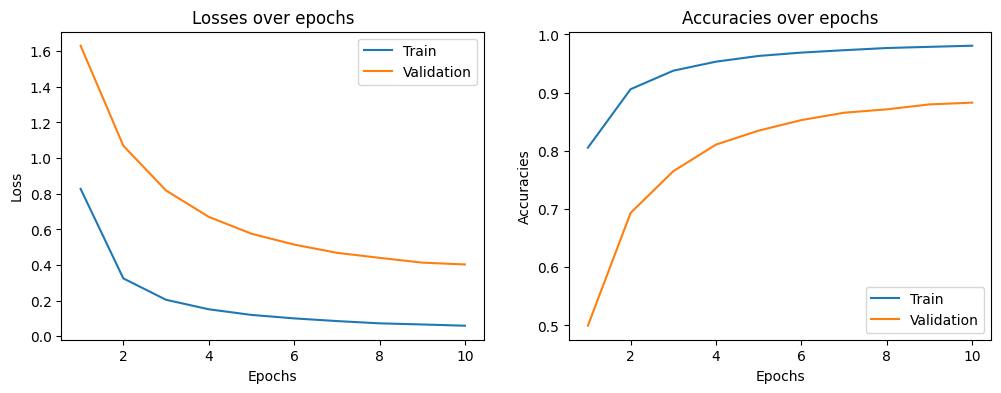

In [41]:
plot_loss_and_accuracy(losses, accuracies, ["Train", "Validation"])

##### Train set performance

In [42]:
loss, acc = evaluation_loop(model, udpos.test_dataloader())
print(f"Test loss = {loss:0.4f} | Test Accuracy: {acc*100:6.4f}")

d:\Projects\POS_Tagging\venv\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Test loss = 0.4292 | Test Accuracy: 87.1244


##### Inference Runtime

In [43]:
%%timeit -n 10
evaluation_loop(model, udpos.test_dataloader())

391 ms ± 6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### 3.2. Bidirectional LSTM

In [44]:
model = PosTagger(num_inputs=NUM_INPUT,
                  embedding_dim=EMBEDDING_DIM,
                  num_hiddens=NUM_HIDDENS,
                  num_outputs=NUM_OUTPUTS,
                  bidirectional=True,
                  num_layers=1,
                  padding_idx=PADDING_IDX)

d:\Projects\POS_Tagging\venv\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [45]:
bi_losses, bi_accuracies = train_epochs(model, udpos, MAX_EPOCHS)

Epoch: 01 in (48.16) secs
	Train Loss: 0.668 | Train Acc: 85.17%
	 Val. Loss: 1.124 |  Val. Acc: 69.11%
Epoch: 02 in (48.68) secs
	Train Loss: 0.197 | Train Acc: 94.00%
	 Val. Loss: 0.726 |  Val. Acc: 78.89%
Epoch: 03 in (48.43) secs
	Train Loss: 0.129 | Train Acc: 96.04%
	 Val. Loss: 0.568 |  Val. Acc: 84.20%
Epoch: 04 in (47.60) secs
	Train Loss: 0.097 | Train Acc: 96.99%
	 Val. Loss: 0.477 |  Val. Acc: 86.82%
Epoch: 05 in (47.97) secs
	Train Loss: 0.075 | Train Acc: 97.69%
	 Val. Loss: 0.435 |  Val. Acc: 86.24%
Epoch: 06 in (47.01) secs
	Train Loss: 0.063 | Train Acc: 98.10%
	 Val. Loss: 0.401 |  Val. Acc: 87.26%
Epoch: 07 in (47.73) secs
	Train Loss: 0.051 | Train Acc: 98.47%
	 Val. Loss: 0.370 |  Val. Acc: 88.54%
Epoch: 08 in (47.75) secs
	Train Loss: 0.043 | Train Acc: 98.69%
	 Val. Loss: 0.359 |  Val. Acc: 88.31%
Epoch: 09 in (48.34) secs
	Train Loss: 0.037 | Train Acc: 98.88%
	 Val. Loss: 0.352 |  Val. Acc: 88.57%
Epoch: 10 in (48.76) secs
	Train Loss: 0.033 | Train Acc: 99.03%

In [46]:
def combine(metrics_1, metrics_2):
    return [(a, b, c, d)
            for (a, b), (c, d) in zip(metrics_1, metrics_2)]

In [47]:
c_losses = combine(losses, bi_losses)
c_accuracies = combine(accuracies, bi_accuracies)

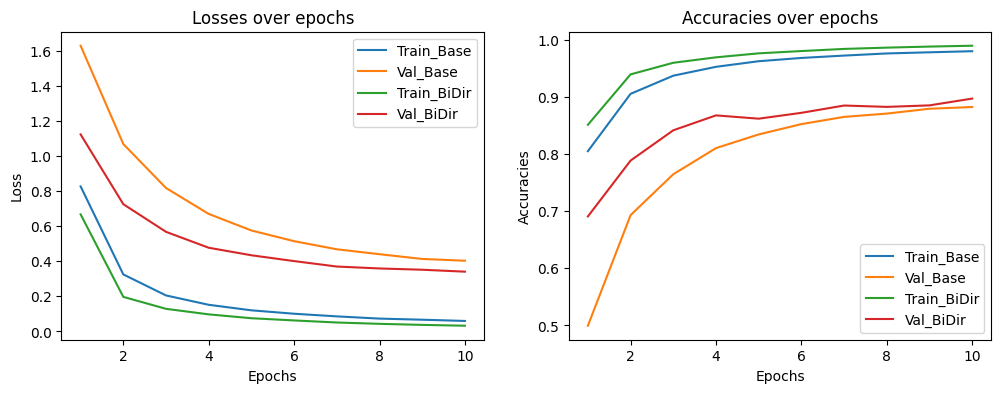

In [48]:
plot_loss_and_accuracy(c_losses, c_accuracies,
                      ["Train_Base", "Val_Base", 
                       "Train_BiDir", "Val_BiDir"])

##### Test Set Performance

In [49]:
loss, acc = evaluation_loop(model, udpos.test_dataloader())
print(f"Test loss = {loss:0.4f} | Test Accuracy: {acc*100:6.4f}")

Test loss = 0.3402 | Test Accuracy: 89.4501


##### Inference Time

In [50]:
%%timeit -n 10
evaluation_loop(model, udpos.test_dataloader())

721 ms ± 3.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### 3.3. Deep Bidirectional LSTM

In [51]:
model = PosTagger(num_inputs=NUM_INPUT,
                  embedding_dim=EMBEDDING_DIM,
                  num_hiddens=NUM_HIDDENS,
                  num_outputs=NUM_OUTPUTS,
                  bidirectional=True,
                  num_layers=2,
                  padding_idx=PADDING_IDX)

In [52]:
dbi_losses, dbi_accuracies = train_epochs(model, udpos, MAX_EPOCHS)

Epoch: 01 in (102.29) secs
	Train Loss: 0.730 | Train Acc: 80.61%
	 Val. Loss: 1.615 |  Val. Acc: 51.73%
Epoch: 02 in (101.77) secs
	Train Loss: 0.255 | Train Acc: 92.06%
	 Val. Loss: 0.903 |  Val. Acc: 72.86%
Epoch: 03 in (102.91) secs
	Train Loss: 0.143 | Train Acc: 95.45%
	 Val. Loss: 0.712 |  Val. Acc: 78.53%
Epoch: 04 in (102.30) secs
	Train Loss: 0.101 | Train Acc: 96.82%
	 Val. Loss: 0.620 |  Val. Acc: 81.28%
Epoch: 05 in (102.90) secs
	Train Loss: 0.075 | Train Acc: 97.70%
	 Val. Loss: 0.536 |  Val. Acc: 83.31%
Epoch: 06 in (102.87) secs
	Train Loss: 0.058 | Train Acc: 98.23%
	 Val. Loss: 0.492 |  Val. Acc: 84.59%
Epoch: 07 in (99.73) secs
	Train Loss: 0.048 | Train Acc: 98.56%
	 Val. Loss: 0.465 |  Val. Acc: 85.79%
Epoch: 08 in (102.08) secs
	Train Loss: 0.039 | Train Acc: 98.85%
	 Val. Loss: 0.450 |  Val. Acc: 86.07%
Epoch: 09 in (101.66) secs
	Train Loss: 0.033 | Train Acc: 99.04%
	 Val. Loss: 0.438 |  Val. Acc: 86.10%
Epoch: 10 in (100.31) secs
	Train Loss: 0.028 | Train Ac

In [53]:
c_losses = combine(losses, dbi_losses)
c_accuracies = combine(accuracies, dbi_accuracies)

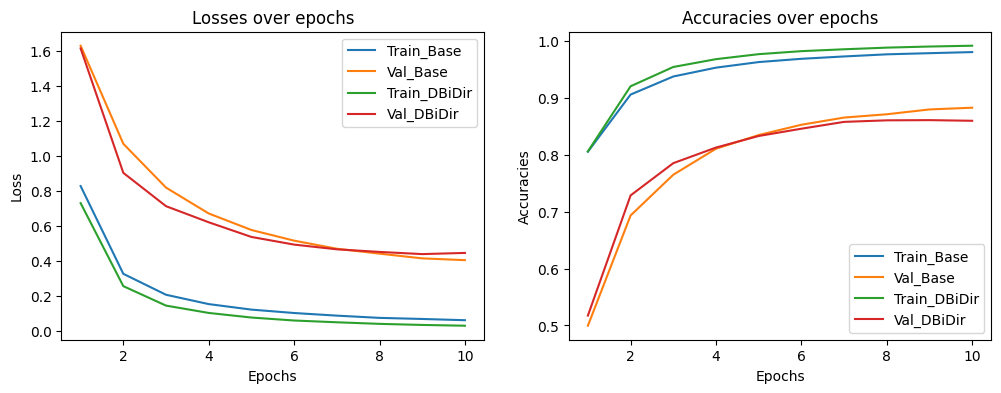

In [54]:
plot_loss_and_accuracy(c_losses, c_accuracies,
                      ["Train_Base", "Val_Base", 
                       "Train_DBiDir", "Val_DBiDir"])

##### Test Set Performance

In [55]:
loss, acc = evaluation_loop(model, udpos.test_dataloader())
print(f"Test loss = {loss:0.4f} | Test Accuracy: {acc*100:6.4f}")

Test loss = 0.4676 | Test Accuracy: 85.4816


##### Inference Times

In [56]:
%%timeit -n 10
evaluation_loop(model, udpos.test_dataloader())

1.41 s ± 6.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
